In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#from scipy.stats import yeojohnson
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans

In [2]:
def moments(row):
    idade = row['idade']
    renda_mensal = row['renda_mensal']
    investimento_total = row['investimento_total']
    
    if 0 <= idade < 16:
        return 'Momento 1'
    elif 16 <= idade < 26:
        return 'Momento 2'
    elif 26 <= idade < 60:
        if renda_mensal >= 5e3:
            if investimento_total < 2e5:
                return 'Momento 6'
            else:
                return 'Momento 7'
        elif (idade < 36) and (renda_mensal < 5e3):
            return 'Momento 3'
        elif (idade < 45) and (renda_mensal < 5e3):
            return 'Momento 4'
        elif renda_mensal < 5e3:
            return 'Momento 5'
    elif idade >= 60:
        if renda_mensal < 5e3:
            return 'Momento 8'
        else:
            return 'Momento 9'

In [3]:
df = pd.read_csv(
    'ldw-base_relacionamento_atual.csv',
    delimiter=';',
    dtype={'cod_carteira': str}
    )\
    .astype(
        {
            'cod_central': str,
            'cod_coop': str,
            'num_conta_principal': str,
            'cod_ua': str,
            'num_cpf_cnpj': str,
            'cod_cnae': str,
            'ano_mes': str,
            'flg_cheque_especial': str,
            'num_ano_mes': str,
            'flg_associado': str,
            'digital_acessou_30d': int,
            'mobi_acessou_30d': int
        }
    )\
    .assign(
        cad_pix=lambda x: x.cad_pix.map({'S': 1, 'N': 0}),
        assoc_desde=lambda x: pd.to_datetime(x.assoc_desde),
        tempo_assoc=lambda x: (pd.Timestamp('2024-11-01') - x.assoc_desde).dt.days,
        ultimo_contato=lambda x: pd.to_datetime(x.ultimo_contato),
        nivel_risco=lambda x: x.nivel_risco.fillna('DEFAULT'),
        score_principalidade=lambda x: x.score_principalidade.fillna(0),
        faixa_principalidade=lambda x: x.faixa_principalidade.replace('MISSING', np.nan).fillna('BAIXA'),
        desc_cbo=lambda x: x.desc_cbo.replace('ESTUDANTE', 'Estudantes'),
        publico_estrategico=lambda x: x.publico_estrategico.fillna('cooperativa'),
        investimento_total=lambda x: x.sld_lci + x.sld_lca + x.sld_fundos + x.sld_dep_a_prazo,
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1),
        flg_sexo=lambda x: [
            'PJ' if x.segmento.loc[i] == "PJ"
            else x.flg_sexo.loc[i]
            for i in range(x.shape[0])
        ],
    )\
    .query(
        '(status_associado == "ATIVO") '
        'and ~renda_mensal.isna() '
        'and (segmento != "AG")'
    )\
    .drop(
        columns=[
            'sld_cred_scr_180_2m', 'sld_cred_sicredi_sas_2m',
            'sld_cred_sicredi_sas_180_2m', 'mc_seguro_agricola',
            'vlr_prej_coobrigacoes', 'vlr_prej_outros', 'sld_cred_moeda',
            'sld_seg_elementares', 'sld_seg_agricola', 'fat_ano',
            'mc_seg_elementares', 'mc_domicilio', 'mc_cred_moeda',
            'qt_cred_moeda', 'qt_seg_elementares', 'qt_seg_agricola',
            'vlr_prej_cred_rural', 'mc_seguro_rural'
        ]
    )\
    .dropna(subset=['idade'])\
    .reset_index(drop=True)
        

df = df\
    .astype(
        {
            col: str
            for col in df.loc[:,df.columns.str.startswith(
                ('prod', 'flg', 'digital',
                 'possui', 'ib', 'mobi', 'fone')
            )].columns
        }
    )\
    .assign(
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1)
    )

df.loc[
    (df.idade <= 15) &
    (df.renda_mensal >= 0),
    'renda_mensal'] = 0

df.loc[
    (df.idade >= 16) &
    (df.renda_mensal < 1000) &
    (~df.desc_cbo.isin(['Estudantes'])),
    'renda_mensal'] = np.nan

df.loc[
    (df.idade >= 18) &
    (df.renda_mensal < 1000) &
    df.desc_cbo.isin(['Estudantes']),
    'renda_mensal'] = df.sld_cred_scr_2m * .3

df.loc[
    (df.idade >= 18) &
    (df.renda_mensal < 1000) &
    df.desc_cbo.isin(['Estudantes']),
    'renda_mensal'] = np.nan

df.loc[df.renda_mensal.isna(), 'renda_mensal'] = df\
    .groupby('desc_cbo')\
    .renda_mensal\
    .transform('mean')

In [4]:
knn = KNNImputer(n_neighbors=10)
knn_cols = df.dropna(subset=['renda_mensal'])\
    .select_dtypes(include=np.number).corr(method='spearman')\
    .renda_mensal.abs().sort_values(ascending=False).head(50).index\
    .tolist()
df_impute_knn = knn.fit_transform(df[knn_cols])
df_impute_knn = pd.DataFrame(
    df_impute_knn,
    columns=knn_cols
    )
df['renda_mensal'] = df_impute_knn.renda_mensal
df = df\
    .assign(
        momentos=lambda x: x.apply(moments, axis=1)
    )\
    .query('desc_cbo != "diretor de produção e operações em empresa pesqueira"')\
    .reset_index(drop=True)

In [6]:
df_cluster = df\
    .loc[:, [
        'idade', 'renda_mensal',
        'tempo_assoc', 'score_principalidade',
        'isa', 'sld_previdencia',
        'qt_investimento_media', 
        #'sld_lci', 'sld_lca',
        #'sld_fundos', 'sld_dep_a_prazo',
        'investimento_total',
        'sld_inad_ca_0'
        ] +
        df.columns[df.columns.str.startswith('sld_seg')].tolist() +
        df.columns[df.columns.str.startswith('sld_cred')].tolist() +
        df.columns[df.columns.str.startswith('mc_') & ~df.columns.isin([
            'mc_assoc', 'mc_assoc_6_meses', 'mc_total'
        ])].tolist() +
        df.filter(like='vlr_prej').columns.tolist()
    ]\
    .assign(
        sld_total_cons=lambda x: x.loc[:, x.columns.str.startswith('sld_')].sum(axis=1)
    )

df_cluster_columns = df_cluster.columns.tolist()
df_cluster = pd.DataFrame(
    StandardScaler().fit_transform(df_cluster),
    columns=df_cluster_columns
    )\
    .assign(
        idade=lambda x: 1500 * x.idade,
        mc_dep_a_prazo=lambda x: 900 * x.mc_dep_a_prazo,
        investimento_total=lambda x: 1500 * x.investimento_total,
        score_principalidade=lambda x: 1500 * x.score_principalidade,
        renda_mensal=lambda x: x.renda_mensal * 2000,
        #sld_total_cons=lambda x: x.sld_total_,
        #isa=lambda x:  800 * x.isa,
    )

In [7]:
class Inertia: 
    def __init__(self, data, cluster_columns=None, set_groups=20):
        self.set_groups = set_groups + 1
        self.data = data
        self.data_cluster = data.loc[:, cluster_columns]
        self.cluster_columns = cluster_columns

    def find_groups(self, n_clusters):
        return KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            random_state=42
            ).fit(self.data_cluster)\
            .labels_
    
    def calc_inertia(self):
        return [
            KMeans(
                n_clusters=i,
                init='k-means++',
                random_state=42
            ).fit(self.data_cluster)\
            .labels_
            for i in range(1, self.set_groups)
        ]

    def plot_inertia(self):
        plt.figure(figsize=(10, 8))
        plt.plot(
            range(1, self.set_groups),
            self.calc_inertia(),
            marker='o', 
            linestyle='--'
        )

In [8]:
for seed in range(43):
    kmeans = KMeans(
        n_clusters=7,
        max_iter=2500,
        tol=1e-16,
        random_state=seed
        ).fit(df_cluster)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}, {seed}")

Number of elements assigned to each cluster: [35716 44294   260     7 52318    99 25668], 0
Number of elements assigned to each cluster: [52318 25668     7 44294    99 35716   260], 1
Number of elements assigned to each cluster: [25170 52439 44578   277     6    39 35853], 2
Number of elements assigned to each cluster: [35853 25170 52439 44578    39     6   277], 3
Number of elements assigned to each cluster: [43125 35333 26862 52000     9    61   972], 4
Number of elements assigned to each cluster: [24525 27113 24728 40207   323     9 41457], 5
Number of elements assigned to each cluster: [35777 25412    55 52379 44457     7   275], 6
Number of elements assigned to each cluster: [25180 35850 44577     6   277 52433    39], 7
Number of elements assigned to each cluster: [  972 51998 43126     9    61 26862 35334], 8
Number of elements assigned to each cluster: [61106 39512     6  3911 53596    28   203], 9
Number of elements assigned to each cluster: [40153 62648     7 54875    56    2

In [9]:
kmeans = KMeans(
    n_clusters=7,
    tol=1e-16,
    max_iter=2500,
    random_state=42
    ).fit(df_cluster)

In [10]:
df = df.assign(
    Grupos=kmeans.labels_
    )\
    .sort_values('Grupos')\
    .astype({'Grupos': str})

In [12]:
#sns.boxplot(
#    data=df\
#        .assign(qt_investimento_media=lambda x: np.log1p(x.qt_investimento_media)),
#    y='mc_dep_a_prazo',
#    hue='Grupos',
#)
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

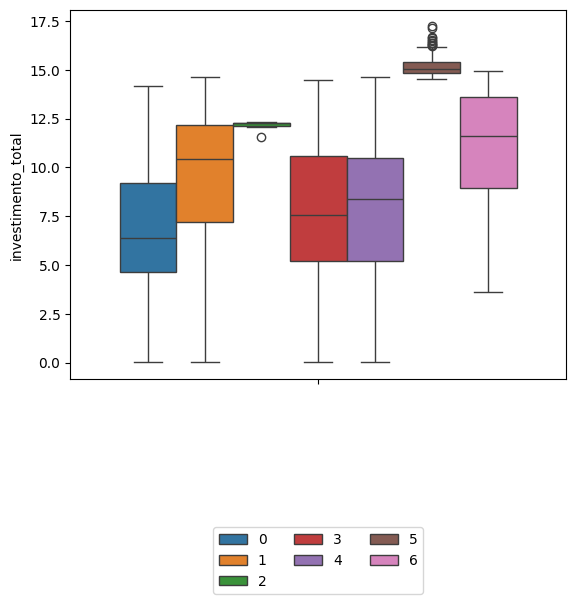

In [13]:
sns.boxplot(
    data=df\
        .assign(investimento_total=lambda x: np.log1p(x.investimento_total))\
        .query('investimento_total != 0'),
    y='investimento_total',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

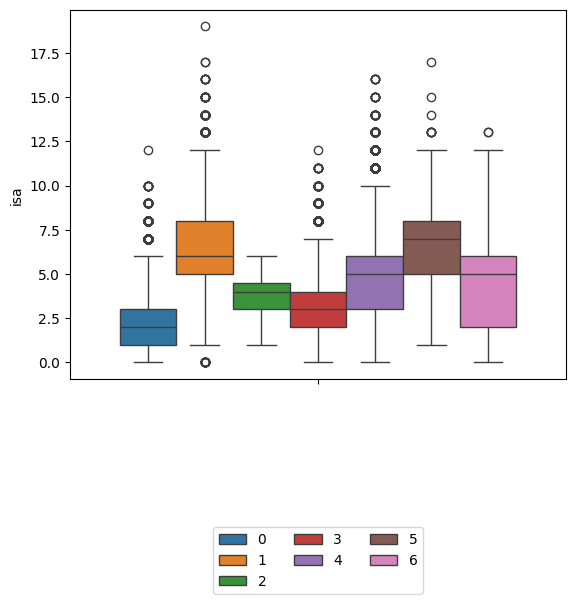

In [14]:
sns.boxplot(
    data=df\
        .assign(renda_mensal=lambda x: np.log1p(x.renda_mensal)),
    y='isa',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

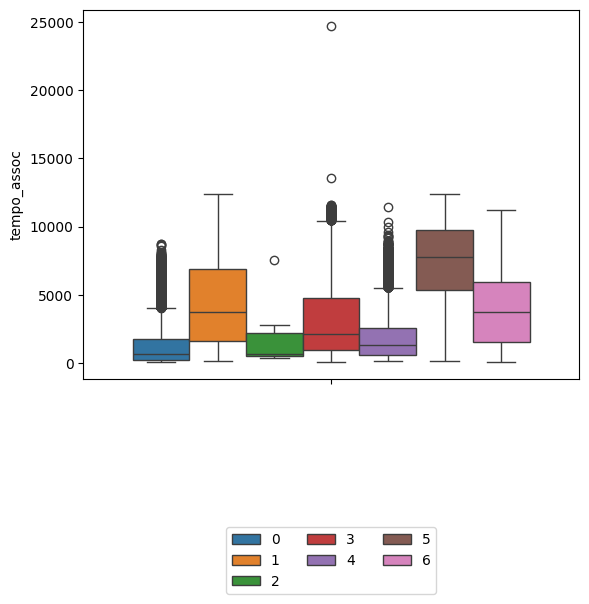

In [15]:
sns.boxplot(
    data=df,
    y='tempo_assoc',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

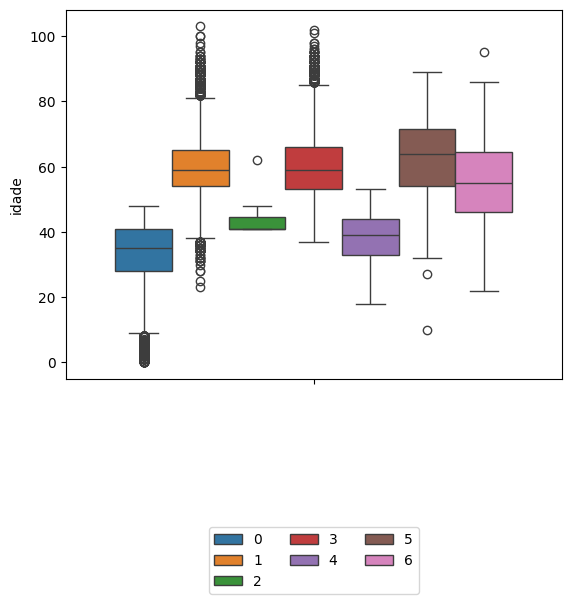

In [16]:
sns.boxplot(
    data=df,
    y='idade',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

<Axes: ylabel='sld_previdencia'>

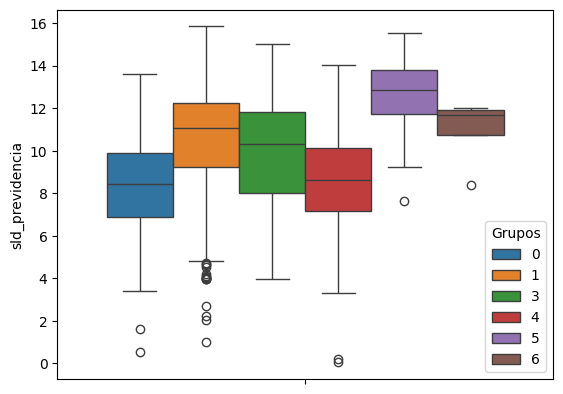

In [19]:
sns.boxplot(
    data=df\
        .assign(
            sld_previdencia=lambda x: np.log1p(x.sld_previdencia)
        )\
        .query('sld_previdencia != 0'),
    y='sld_previdencia',
    hue='Grupos'
)

<Axes: ylabel='renda_mensal'>

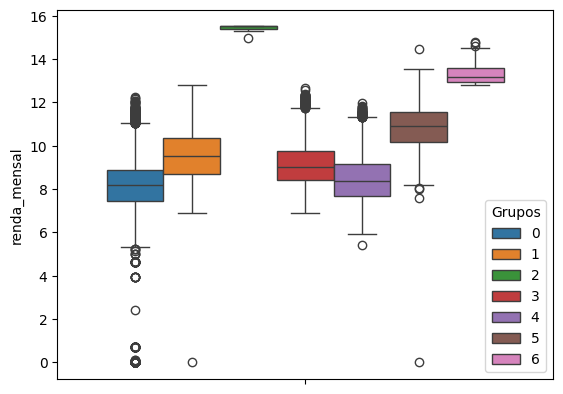

In [17]:
sns.boxplot(
    data=df\
        .assign(
            renda_mensal=lambda x: np.log1p(x.renda_mensal)
        ),
    y='renda_mensal',
    hue='Grupos'
)

In [203]:
prod_tot = df\
    .loc[:, df.columns.str.startswith('prod_')]\
    .stack()\
    .reset_index(name='possui')\
    .rename(columns={'level_1': 'produto'})\
    .drop(columns=['level_0'])\
    .astype({'possui': int})\
    .groupby('produto').possui\
    .sum().reset_index()\
    .assign(
        possui=lambda x: (x.possui / df.shape[0]) * 100
    )\
    .sort_values('possui')

<Axes: xlabel='idade', ylabel='renda_mensal'>

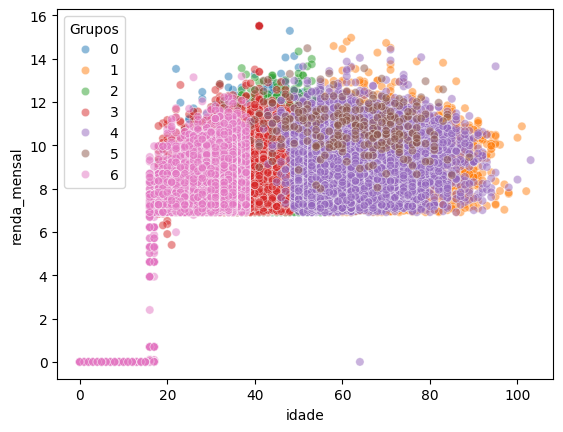

In [418]:
sns.scatterplot(
    data=df\
        .assign(
            renda_mensal=lambda x: np.log1p(x.renda_mensal)
        ),
    x='idade',
    y='renda_mensal',
    alpha=.5,
    hue='Grupos'
)

In [ ]:
stack_df = df.loc[:,
                df.columns[df.columns.str.startswith('prod_')].tolist()
                + ['Grupos']
            ]\
            .set_index('Grupos')\
            .stack()\
            .reset_index(name='contem')\
            .astype({'contem': int})\
            .rename(columns={'level_1': 'produto'})\
            .groupby(['Grupos', 'produto'])\
            .contem\
            .sum()\
            .reset_index(name='total_produto_grupo')

In [310]:
#wcss = []
#for i in range(1, 21):
#    kmeans_pca = KMeans(
#        n_clusters=i,
#        init='k-means++',
#        random_state=42
#    )
#    kmeans_pca.fit(df_cluster)
#    wcss.append(kmeans_pca.inertia_)

In [311]:
#plt.figure(figsize=(10, 8))
#plt.plot(range(1, 21), wcss, marker='o', linestyle='--')

In [419]:
df.to_csv('relacionamento_clusters.csv', index=False)